# Data Science Unit 4 Sprint Challenge 1 — Tree Ensembles

### Chicago Food Inspections

For this Sprint Challenge, you'll use a dataset with information from inspections of restaurants and other food establishments in Chicago from January 1, 2010 to the present. 

[See this PDF](https://data.cityofchicago.org/api/assets/BAD5301B-681A-4202-9D25-51B2CAE672FF) for descriptions of the data elements included in this dataset.

According to [Chicago Department of Public Health — Food Protection Services](https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_restaurants/svcs/food-protection-services.html), "Chicago is home to 16,000 food establishments like restaurants, grocery stores, bakeries, wholesalers, lunchrooms, mobile food vendors and more. Our business is food safety and sanitation with one goal, to prevent the spread of food-borne disease. We do this by inspecting food businesses, responding to complaints and food recalls." 

#### Your challenge: Predict whether inspections failed

The target is the `Fail` column.

- When the food establishment failed the inspection, the target is `1`.
- When the establishment passed, the target is `0`.

#### Run this cell to load the data:

In [0]:
import pandas as pd

train_url = 'https://drive.google.com/uc?export=download&id=13_tP9JpLcZHSPVpWcua4t2rY44K_s4H5'
test_url  = 'https://drive.google.com/uc?export=download&id=1GkDHjsiGrzOXoF_xcYjdzBTSjOIi3g5a'

train = pd.read_csv(train_url)
test  = pd.read_csv(test_url)

assert train.shape == (51916, 17)
assert test.shape  == (17306, 17)

### Part 1: Preprocessing

You may choose which features you want to use, and whether/how you will preprocess them. You may use any tools 
and techniques for categorical encoding. (Pandas, category_encoders, sklearn.preprocessing, or any other library.)

_To earn a score of 3 for this part, engineer new features, and use any alternative categorical encoding instead of 
One-Hot or Ordinal/Label encoding._

In [5]:
train['Fail'].value_counts(normalize=True)

0    0.74139
1    0.25861
Name: Fail, dtype: float64

In [6]:
train = train.drop(columns = ['Location', 'AKA Name', 'Inspection ID', 'License #', 'State','City'])
train.head()

,DBA Name,Facility Type,Risk,Address,Zip,Inspection Date,Inspection Type,Violations,Latitude,Longitude,Fail
0,"TOM YUM RICE & NOODLE, INC.",Restaurant,Risk 1 (High),608 W BARRY,60657.0,2017-09-15T00:00:00,Canvass,3. POTENTIALLY HAZARDOUS FOOD MEETS TEMPERATUR...,41.938007,-87.644755,1
1,FILLING STATION & CONVENIENCE STORE,Grocery Store,Risk 3 (Low),6646-6658 S WESTERN AVE,60636.0,2011-10-20T00:00:00,Complaint Re-Inspection,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,41.772402,-87.683603,0
2,A P DELI,Restaurant,Risk 1 (High),2025 E 75TH ST,60649.0,2016-04-05T00:00:00,Canvass Re-Inspection,"35. WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTR...",41.758779,-87.575054,0
3,FRANK'S CHICAGO SHRIMP HOUSE,Restaurant,Risk 2 (Medium),4459 S ARCHER AVE,60632.0,2016-04-29T00:00:00,Canvass,38. VENTILATION: ROOMS AND EQUIPMENT VENTED AS...,41.812181,-87.707125,0
4,MORRILL,School,Risk 1 (High),6011 S Rockwell (2600W) AVE,60629.0,2011-01-10T00:00:00,Canvass,"34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOO...",NaN,NaN,0


In [7]:
test = test.drop(columns = ['Location', 'AKA Name', 'Inspection ID', 'License #', 'State', 'City'])
test.head()

,DBA Name,Facility Type,Risk,Address,Zip,Inspection Date,Inspection Type,Violations,Latitude,Longitude,Fail
0,7 - ELEVEN,Grocery Store,Risk 2 (Medium),600 S DEARBORN,60605.0,2011-03-22T00:00:00,Canvass,33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSI...,41.874481,-87.629357,0
1,TAQUERIA LOS GALLOS INC,Restaurant,Risk 1 (High),4209-4211 W 26TH ST,60623.0,2015-09-15T00:00:00,Canvass,"30. FOOD IN ORIGINAL CONTAINER, PROPERLY LABEL...",41.844070,-87.729807,0
2,TROTTER'S TO GO,Restaurant,Risk 1 (High),1337 W FULLERTON AVE,60614.0,2012-03-02T00:00:00,Canvass,"34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOO...",41.925128,-87.662041,0
3,BIG G'S PIZZA,Restaurant,Risk 1 (High),1132 W TAYLOR ST,60607.0,2016-10-04T00:00:00,Canvass Re-Inspection,"14. PREVIOUS SERIOUS VIOLATION CORRECTED, 7-42...",41.869546,-87.655501,1
4,SOUTH CENTRAL COMMUNITY SERVICES ELEMENTARY,School,Risk 2 (Medium),1021 E 83RD,60619.0,2016-04-08T00:00:00,Canvass,18. NO EVIDENCE OF RODENT OR INSECT OUTER OPEN...,41.743933,-87.599291,1


In [8]:
train.isna().sum()

DBA Name              0
Facility Type       224
Risk                 12
Address               0
Zip                  26
Inspection Date       0
Inspection Type       1
Violations         9655
Latitude            198
Longitude           198
Fail                  0
dtype: int64

In [9]:
test.isna().sum()

DBA Name              0
Facility Type        87
Risk                  7
Address               0
Zip                   8
Inspection Date       0
Inspection Type       0
Violations         3280
Latitude             61
Longitude            61
Fail                  0
dtype: int64

In [0]:
# Clean up NaN values

train[['Facility Type']] = train[['Facility Type']].fillna(value='Unknown')
train[['Risk']] = train[['Risk']].fillna(value='Unknown')
train[['Inspection Type']] = train[['Inspection Type']].fillna(value='Unknown')
train[['Violations']] = train[['Violations']].fillna(value='0')

test[['Facility Type']] = test[['Facility Type']].fillna(value='Unknown')
test[['Risk']] = test[['Risk']].fillna(value='Unknown')
test[['Inspection Type']] = test[['Inspection Type']].fillna(value='Unknown')
test[['Violations']] = test[['Violations']].fillna(value='0')

In [11]:
train.isna().sum()

DBA Name             0
Facility Type        0
Risk                 0
Address              0
Zip                 26
Inspection Date      0
Inspection Type      0
Violations           0
Latitude           198
Longitude          198
Fail                 0
dtype: int64

In [12]:
test.isna().sum()

DBA Name            0
Facility Type       0
Risk                0
Address             0
Zip                 8
Inspection Date     0
Inspection Type     0
Violations          0
Latitude           61
Longitude          61
Fail                0
dtype: int64

In [13]:
train.describe(include='all')
# License # drop?
# Facility Type - Unknown
# Risk - Unknown
# City - Unknown
# Zip - drop rows?
# Lat/Long - drop rows?

,DBA Name,Facility Type,Risk,Address,Zip,Inspection Date,Inspection Type,Violations,Latitude,Longitude,Fail
count,51916,51916,51916,51916,51890.000000,51916,51916,51916,51718.000000,51718.000000,51916.000000
unique,17049,330,4,13954,NaN,2257,52,42165,NaN,NaN,NaN
top,SUBWAY,Restaurant,Risk 1 (High),11601 W TOUHY AVE,NaN,2017-03-23T00:00:00,Canvass,0,NaN,NaN,NaN
freq,654,34264,37731,741,NaN,50,24170,9655,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,60628.834669,NaN,NaN,NaN,41.879568,-87.676663,0.258610
std,NaN,NaN,NaN,NaN,22.736963,NaN,NaN,NaN,0.081126,0.059509,0.437875
min,NaN,NaN,NaN,NaN,60007.000000,NaN,NaN,NaN,41.644670,-87.914428,0.000000
25%,NaN,NaN,NaN,NaN,60614.000000,NaN,NaN,NaN,41.830296,-87.707857,0.000000
50%,NaN,NaN,NaN,NaN,60625.000000,NaN,NaN,NaN,41.890166,-87.666524,0.000000
75%,NaN,NaN,NaN,NaN,60643.000000,NaN,NaN,NaN,41.939167,-87.634461,1.000000


In [0]:
# New feature with count of Violations

train['num_violations'] = train['Violations'].str.split('|').apply(lambda x: len(x))
test['num_violations'] = test['Violations'].str.split('|').apply(lambda x: len(x))

In [15]:
X = train.dropna() #Drop rows with NaN for zip & lat/long since there aren't many
y = X['Fail']
X = X.drop(columns = ['Fail'])
X_test = test.dropna() #Drop rows with NaN for zip & lat/long since there aren't many
y_test = X_test['Fail']
X_test = X_test.drop(columns = ['Fail'])

print(X.shape)
print(y.shape)
print(X_test.shape)
print(y_test.shape)

(51698, 11)
(51698,)
(17237, 11)
(17237,)


In [17]:
!pip install category_encoders

    100% |████████████████████████████████| 61kB 2.2MB/s 


In [0]:
import category_encoders as ce

encoder = ce.OrdinalEncoder()
X = encoder.fit_transform(X)
X_test = encoder.fit_transform(X_test)

In [19]:
X.head()

,DBA Name,Facility Type,Risk,Address,Zip,Inspection Date,Inspection Type,Violations,Latitude,Longitude,num_violations
0,1,1,1,1,60657.0,1,1,1,41.938007,-87.644755,5
1,2,2,2,2,60636.0,2,2,2,41.772402,-87.683603,7
2,3,1,1,3,60649.0,3,3,3,41.758779,-87.575054,1
3,4,1,3,4,60632.0,4,1,4,41.812181,-87.707125,2
5,5,3,1,5,60614.0,5,1,5,41.932632,-87.647973,7


### Part 2: Modeling

Fit a Random Forest or Gradient Boosting model with the train set. (You may use scikit-learn, xgboost, or any other library.) Use cross-validation to estimate an ROC AUC validation score.

Use your model to predict probabilities for the test set. Get an ROC AUC test score >= 0.60.

_To earn a score of 3 for this part, get an ROC AUC test score >= 0.70._

In [20]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score

gb = GradientBoostingClassifier()
cross_val_score(gb, X, y, scoring='accuracy', cv=5, n_jobs=-1)

array([0.61261   , 0.82562863, 0.82464455, 0.81622981, 0.76032498])

In [21]:
# X = X.drop(columns=['DBA Name'])
# X_test = X_test.drop(columns=['DBA Name'])

gb.fit(X, y)
pd.Series(gb.feature_importances_, X.columns)

DBA Name           0.001432
Facility Type      0.021352
Risk               0.013094
Address            0.001264
Zip                0.003172
Inspection Date    0.001951
Inspection Type    0.148156
Violations         0.003156
Latitude           0.006148
Longitude          0.008198
num_violations     0.792076
dtype: float64

In [22]:
gb.fit(X, y)
y_pred_proba = gb.predict_proba(X_test)[:,1]
print('Validation ROC AUC:', roc_auc_score(y_test, y_pred_proba))

Validation ROC AUC: 0.8296918198835503


In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline

pipe = make_pipeline( 
    RandomForestClassifier(
        n_estimators=100, 
        class_weight='balanced', 
        min_samples_leaf=0.002, 
        oob_score=True, 
        n_jobs=-1)
)

cross_val_score(pipe, X, y, cv=5, scoring='roc_auc', verbose=10)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] ....................... , score=0.8003087803160457, total=   5.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.9s remaining:    0.0s


[CV] ....................... , score=0.8369106073745003, total=   6.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   12.0s remaining:    0.0s


[CV] ....................... , score=0.8423200596814971, total=   6.1s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   18.0s remaining:    0.0s


[CV] ....................... , score=0.8293723094706827, total=   6.1s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   24.1s remaining:    0.0s


[CV] ....................... , score=0.8379889524079268, total=   5.8s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   29.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   29.9s finished


array([0.80030878, 0.83691061, 0.84232006, 0.82937231, 0.83798895])

In [24]:
rf =     RandomForestClassifier(
        n_estimators=100, 
        class_weight='balanced', 
        min_samples_leaf=0.005, 
        oob_score=True, 
        n_jobs=-1)

rf.fit(X,y)

y_pred_proba = gb.predict_proba(X_test)[:,1]
print('Validation ROC AUC:', roc_auc_score(y_test, y_pred_proba))

Validation ROC AUC: 0.8296918198835503


### Part 3: Visualization

Make one visualization for model interpretation. (You may use any libraries.) Choose one of these types:
- Feature Importances
- Permutation Importances
- Partial Dependence Plot

_To earn a score of 3 for this part, make at least two of these visualization types._

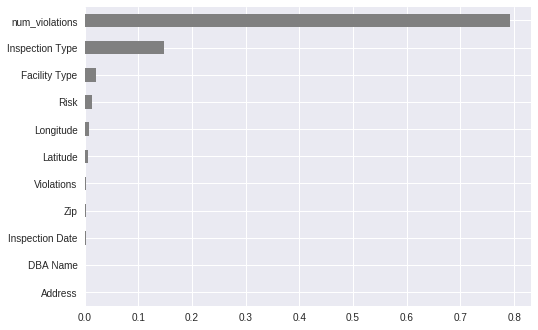

In [25]:
pd.Series(gb.feature_importances_, X.columns).sort_values().plot.barh(color='grey');

In [2]:
!pip install eli5

    100% |████████████████████████████████| 102kB 2.6MB/s 


In [27]:
import eli5
from eli5.sklearn import PermutationImportance

gb.fit(X, y)
permuter = PermutationImportance(gb, scoring='roc_auc', n_iter=1, cv='prefit')
permuter.fit(X, y)

PermutationImportance(cv='prefit',
           estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
           n_iter=1, random_state=None, refit=True, scoring='roc_auc')

In [29]:
eli5.show_weights(permuter, top=None, feature_names=X.columns.tolist())

Weight,Feature
0.2506 ± 0.0000,num_violations
0.0705 ± 0.0000,Inspection Type
0.0063 ± 0.0000,Facility Type
0.0032 ± 0.0000,Risk
0.0028 ± 0.0000,Longitude
0.0015 ± 0.0000,Violations
0.0013 ± 0.0000,Latitude
0.0012 ± 0.0000,Zip
0.0008 ± 0.0000,DBA Name
0.0006 ± 0.0000,Inspection Date


In [30]:
!pip install pdpbox

    100% |████████████████████████████████| 57.7MB 478kB/s 
  Stored in directory: /root/.cache/pip/wheels/7d/08/51/63fd122b04a2c87d780464eeffb94867c75bd96a64d500a3fe
Successfully built pdpbox


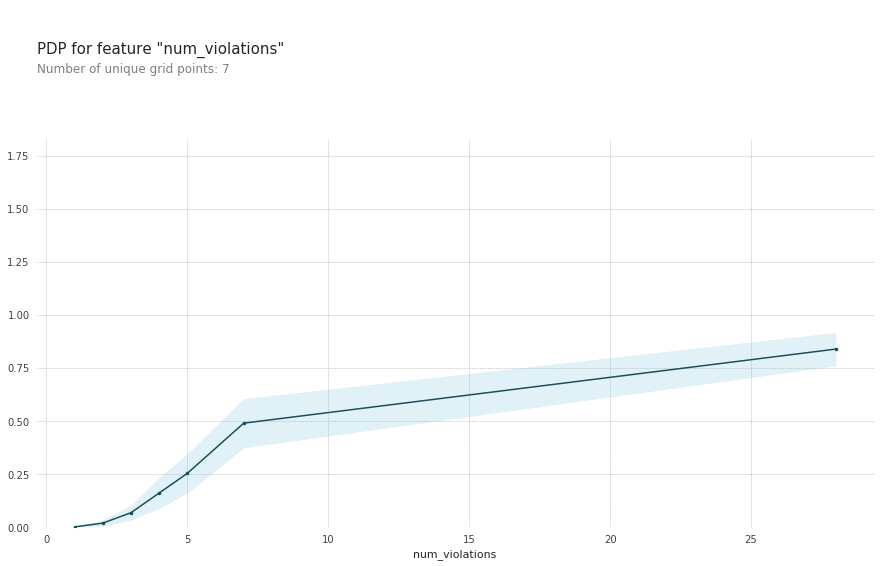

In [31]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature='num_violations'
pdp_isolated = pdp_isolate(model=gb, dataset=X, model_features=X.columns, 
                           feature=feature)

pdp_plot(pdp_isolated, feature);